## Convolution Responses

In [1]:
from skimage.io import imread
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

Read the image

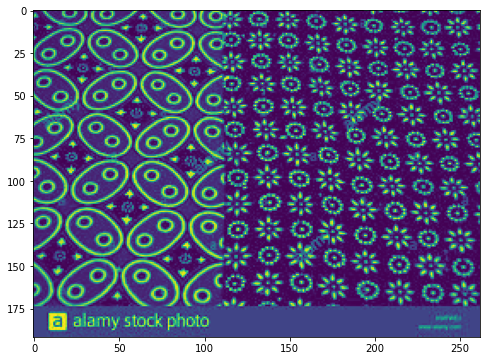

In [2]:
img = imread('circle_img.png')
plt.figure(figsize = (8,10))
plt.imshow(img)

In [3]:
img

array([[ 25,   7,  10, ...,   3,  69, 120],
       [  4,   4,  10, ...,  36, 203, 197],
       [ 90, 129,  19, ...,   5,  60,   2],
       ...,
       [ 52,  52,  52, ...,  52,  52,  52],
       [ 52,  52,  52, ...,  52,  52,  52],
       [ 52,  52,  52, ...,  52,  52,  52]], dtype=uint8)

## 1) Find the centers of flower-like patterns. Let us denote the image by $A\in \mathbb{R}^{H\times W}$.

Recall that the unique solution of the optimization problem ($x_0 \neq 0$)
$$
\begin{cases}
<x, x_0> \longrightarrow max \\
\|x\| = 1
\end{cases}
\qquad \qquad (*)
$$
is $x = \frac{x_0}{\|x_0\|}$.

### If we have a repeated pattern on an image, we can detect it by the following way:
- let's denote an instance of this pattern by $\tilde{\omega}\in \mathbb{R}^{h\times w}$.
- let $\tilde{\omega}$ is repeated in the image on the positions $k_1, k_2, \ldots, k_m$, i.e. the part (of the image $A$) of size $h\times w$ centered in $k_j$th pixel (for $j\in\{1,\ldots, m\}$) is equal (in practise similar) to the pattern $\tilde{\omega}$. We need to find $\{k_1, \ldots, k_m\}$.
- let's denote the part (of the image $A$) of size $h\times w$ centered in $k$th pixel  by $\omega_k$. So, we will get that 
$$
\omega_k \approx \tilde{\omega} \; \mbox{ for } \; k\in\{k_1,\ldots, k_m\}
$$
- so let's determine the $k$s, for which $\omega_k$ is similar to the $\tilde{\omega}$. 
- we define similarity of two vectors $u, v\in \mathbb{R}^{N}$ (here $N = h\cdot w$) by the cross-correlation of them (the problem $(*)$ gives some intuition to interpret this measure as similarity): 
$$
similarity(u,v) = <\frac{u}{\|u_0\|}, \frac{v}{\|v_0\|}>
$$
- so we need to find the $\omega_k$s, for which their cross-correlation with the $\tilde{\omega}$ is high, i.e. the dot product
$$
<\frac{\omega_k}{\|\omega_k\|}, \frac{\tilde{\omega}}{\|\tilde{\omega}\|}>
$$
is high.
- Since the term $\|\tilde{\omega}\|$ does not depend on $k$, we need to find such $k$s, for which $<\frac{\omega_k}{\|\omega_k\|}, \tilde{\omega}>$ is high.


### Hence, let's obtain an image $B$ with $k$th entry equals to $<\frac{\omega_k}{\|\omega_k\|}, \tilde{\omega}>$, then observe high values of $B$.

In [4]:
def get_image_convolution(img, kernel):
    img_H = img.shape[0]
    img_W = img.shape[1]
    kernel_H = kernel.shape[0]
    kernel_W = kernel.shape[1]
    # to get the same size the output as input: n + 2 * padding - kernel_W + 1 = n => padding = ( kernel_W - 1 ) / 2 
    padding = (kernel_W - 1) // 2
    image = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    output = np.zeros((img_H, img_W), dtype="float32")
    for y in np.arange(padding, img_H + padding):
        for x in np.arange(padding, img_W + padding):
            roi = image[y - padding:y + padding + 1, x - padding:x + padding + 1]
            k = (roi * kernel).sum()
            output[y - padding, x - padding] = k
    return output

In [5]:
def get_overline(img, kernel):
    img_H = img.shape[0]
    img_W = img.shape[1]
    kernel_H = kernel.shape[0]
    kernel_W = kernel.shape[1]
    s = (kernel_H, kernel_W)
    kernel_ones = np.ones(s)
     # to get the same size the output as input: n + 2 * padding - kernel_W + 1 = n => padding = ( kernel_W - 1 ) / 2 
    padding = (kernel_W - 1) // 2
    image = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    output = np.zeros((img_H, img_W), dtype="float32")
    for y in np.arange(padding, img_H + padding):
        for x in np.arange(padding, img_W + padding):
            roi = image[y - padding:y + padding + 1, x - padding:x + padding + 1]
            k = (roi * kernel_ones).sum()
            output[y - padding, x - padding] = k
    return output

In [6]:
def get_pattern(img, kernel): 
    tilde_A = get_image_convolution(img, kernel)
    overline_A =  get_overline(img, kernel)
    result = tilde_A / overline_A 
    return result

Now as we have the image, it remains to get the instance of the pattern (a flower from the image $A$).

In [7]:
t, l, b, r = 0,0,3,3 # TODO determine the coordinates of an instance of the pattern using the image $A$
kernel = img[t:b, l:r]

In [8]:
kernel

array([[ 25,   7,  10],
       [  4,   4,  10],
       [ 90, 129,  19]], dtype=uint8)

Get the image $B$

In [9]:
result = get_pattern(img/255., kernel/255.)
result

array([[0.07470588, 0.08457516, 0.16307189, ..., 0.11732326, 0.21642311,
        0.29587534],
       [0.2174578 , 0.34225556, 0.28433314, ..., 0.05252525, 0.07285654,
        0.05917292],
       [0.18263942, 0.24464475, 0.258352  , ..., 0.06040386, 0.04096967,
        0.05849391],
       ...,
       [0.11699346, 0.1298475 , 0.1298475 , ..., 0.1298475 , 0.1298475 ,
        0.16928105],
       [0.11699346, 0.1298475 , 0.1298475 , ..., 0.1298475 , 0.1298475 ,
        0.16928105],
       [0.03039216, 0.03921568, 0.03921568, ..., 0.03921568, 0.03921568,
        0.03921568]], dtype=float32)

Normalize the image $B$ to get values from [0,1].

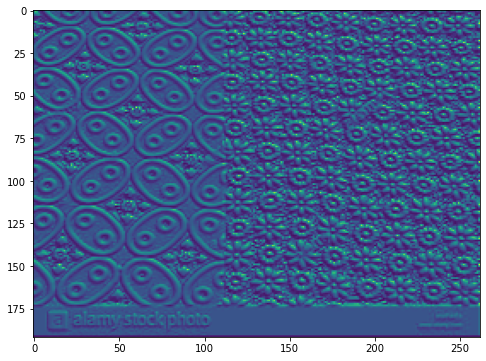

In [10]:
result = result / result.max()
plt.figure(figsize = (8,10))
plt.imshow(result)

Now let's take from $B$ only high values.

In [11]:
'define some threshold'
treshold = 0.5 # TODO change the threshold to get more accurate results.
centers = result.copy()
centers[result>=treshold] = 1
centers[result<treshold] = 0

Visualize the result

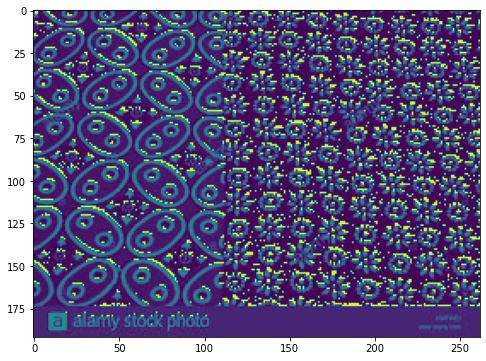

In [12]:
vis = img/255.
vis[centers==1] = 1
vis[centers!=1] *= 0.5
plt.figure(figsize = (8,10))
plt.imshow(vis)

## 2) Let a video is given. In the video a person is showing some hand gestures. Your task is to determine if at the moment person shows hand palm or not.

## So, find the frames of this video, where the person's gesture is hand palm !

Reading the video-file and partitioning it to frames with frequency 2 frames per second. It will take some time (if you have issues with RAM, you can keep downsampled versions of frames).

In [13]:
import cv2
import time
from tqdm import tqdm
from skimage.color import rgb2gray

Making the extracted frames grayscaled images:

In [15]:
# import SimpleCV # tried to use SimpleCV and haarcascade but got many errors. Problems were because of both python2 and python3 versions.

In [35]:
# import glob
# # global variables
# bg = None
# 
# def segment(image, threshold=25):
#     global bg
#     # find the absolute difference between background and current frame
#     diff = cv2.absdiff(bg.astype("uint8"), image)
# 
#     # threshold the diff image so that we get the foreground
#     thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]
# 
#     # get the contours in the thresholded image
#     (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 
#     # return None, if no contours detected
#     if len(cnts) == 0:
#         return
#     else:
#         # based on contour area, get the maximum contour which is the hand
#         segmented = max(cnts, key=cv2.contourArea)
#         return (thresholded, segmented)
#     
#     
# def run_avg(image, aWeight):
#     global bg
#     # initialize the background
#     if bg is None:
#         bg = image.copy().astype("float")
#         return
# 
#     # compute weighted average, accumulate it and update the background
#     cv2.accumulateWeighted(image, bg, aWeight)

In [38]:
# frames_gr = []
# 
# num_frames = 0
# for frame in tqdm(frames):
#     num_frames += 1
#     # resize the frame
#     frame = cv2.resize(frame, (700,700))
#     # flip the frame so that it is not the mirror view
#     #frame = cv2.flip(frame, 1)
#     # clone the frame
#     clone = frame.copy()
#     # get the height and width of the frame
#     (height, width) = frame.shape[:2]
# 
#     # get the ROI
#     roi = frame[top:bottom, right:left]
# 
#     # convert the roi to grayscale and blur it
#     gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (7, 7), 0)
#     
#     if num_frames < 30:
#         run_avg(gray, 0.5)
#     else:
#         # segment the hand region
#         hand = segment(gray)
#     
#     if hand is not None:
#         # if yes, unpack the thresholded image and
#         # segmented region
#         (thresholded, segmented) = hand
#         # draw the segmented region and display the frame
#         cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))
#     # draw the segmented hand
#     cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)
# 
#     # display the frame with segmented hand
#     cv2.imshow("Video Feed", clone)
# 
#     # observe the keypress by the user
#     keypress = cv2.waitKey(0)
#     #frames_gr.append(rgb2gray(frame[:,:,::-1]))
#     
# # When everything done, release the video capture object
# vidcap.release()
# # Closes all the frames
# cv2.destroyAllWindows()
# 

In [ ]:
##  # gets contours for images.
##  for frame in frames_gr:
##  
##  #    # Convert the captured frame into RGB
##       img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
##       img = Image.fromarray(img, 'RGB')      
##  #    # cv2.THRESH_BINARY: If pixel intensity is greater than the set threshold(70), value set to 255, else set to 0 (black).
##  #    ## ret is threshold used, th is thresholded image. 
##       ret, th = cv2.threshold(frame, 200, 255, cv2.THRESH_BINARY) 
##  #    ## RETR_TREE: retrieves all of the contours and reconstructs a full hierarchy of nested contours.
##  #    ## CHAIN_APPROX_SIMPLE: compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, an up-right rectangular contour is encoded with 4 points.
##       contours,_= cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
##  #    #hull = [cv2.convexHull(c) for c in contours]  
##  #    # Draw all contours 
##  #    # -1 signifies img all contours 
##  #    #final =cv2.drawContours(img, hull, -1, (0, 255, 0))   
##       cv2.imshow("Original image ", img)
##  #    #cv2.imshow("covex hull ", final)
##       cv2.waitKey(0)
##       break
##  cv2.destroyAllWindows()

## The rest complete yourself. Try to obtain as high accuracy as possible. Accuracy is measured by the formula $\frac{N_s}{N}$, where $N_s$ is the number of right predictions and $N$ is the number of frames.

## Be creative, you can do it :)

In [ ]:
import cv2
import imutils
import numpy as np

# global variables
bg = None

# To find the running average over the background
def run_avg(image, aWeight):
    global bg
    # initialize the background
    if bg is None:
        bg = image.copy().astype("float")
        return
    # compute weighted average, accumulate it and update the background
    cv2.accumulateWeighted(image, bg, aWeight)

def segment(image, threshold=25):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

if __name__ == "__main__":
    # initialize weight for running average
    aWeight = 0.3

    # get the reference to the webcam
    camera = cv2.VideoCapture(cv2.samples.findFileOrKeep('gesture_video.mov'))

    # region of interest (ROI) coordinates
    top, right, bottom, left = 10, 350, 225, 590

    # initialize num of frames
    num_frames = 0

    # keep looping, until interrupted
    while(True):
        # get the current frame
        (grabbed, frame) = camera.read()

        # resize the frame
        frame = imutils.resize(frame, width=700)

        # flip the frame so that it is not the mirror view
        #frame = cv2.flip(frame, 1)

        # clone the frame
        clone = frame.copy()

        # get the height and width of the frame
        (height, width) = frame.shape[:2]

        # get the ROI
        roi = frame[top:bottom, right:left]

        # convert the roi to grayscale and blur it
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # to get the background, keep looking till a threshold is reached
        # so that our running average model gets calibrated
        if num_frames < 30:
            run_avg(gray, aWeight)
        else:
            # segment the hand region
            hand = segment(gray)

            # check whether hand region is segmented
            if hand is not None:
                # if yes, unpack the thresholded image and
                # segmented region
                (thresholded, segmented) = hand

                # draw the segmented region and display the frame
                cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))
                cv2.imshow("Thesholded", thresholded)

        # increment the number of frames
        num_frames += 1

        # display the frame with segmented hand
        cv2.imshow("Video Feed", clone)

        # observe the keypress by the user
        keypress = cv2.waitKey(1) & 0xFF

        # if the user pressed "q", then stop looping
        if keypress == ord("q"):
            break

# free up memory
camera.release()
cv2.destroyAllWindows()